Implementation of - https://arxiv.org/pdf/2003.01031.pdf

# Loading Data

## Libraries

Installing additional libraries to support the models
1. SHAP: Will be needed to calculate the SHAP values for our dataset to help with the poisoining
2. XGBoost: The model we will be using for our dataset to display the poisoning results
3. TQDM: Progress Bar

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.4 MB/s 


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tqdm
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

## Label Encoding

Link to the Data File: https://drive.google.com/file/d/13s93kXZkmh92lyqan4TPPaoSdhcYu3a_/view?usp=sharing

In [ ]:
drive.mount('/content/gdrive')

# Please provide path to the datafile (link shared above)
df2 = pd.read_csv('/content/gdrive/MyDrive/Research/Robust Boosting/Robust_Boosting_Project_Shared Folder/Datasets/1400k-data.csv',  index_col=0)

df2.reset_index(drop=True, inplace=True)

Mounted at /content/gdrive


In [ ]:
labels = df2.y.values.copy()

y = preprocessing.LabelEncoder().fit_transform(df2['y'])
df2.drop('y', axis=1, inplace=True)

## Convert into Binary

There are 6 classes in the original data, we are conveting it inro a binary classification problem by taking WhatsApp as 1 and rest as 0. Final labels:

WhatsApp : 1

Other Platforms : 0

In [ ]:
label = np.where(y == 4, 1, 0)

In [ ]:
np.unique(label)

array([0, 1])

# Initial Model : Train original XGBoost on the original data

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(df2, label, test_size=0.5, random_state=42)

In [ ]:
xgb = XGBClassifier()
xgb.fit(np.array(X_train), y_train)

print('XGB AUC: ' + str(roc_auc_score(y_test, xgb.predict_proba(np.array(X_test))[:, 1])))
print('XGB Accuracy: ' + str(accuracy_score(y_test, xgb.predict(np.array(X_test)))))

XGB AUC: 0.9999493059009017
XGB Accuracy: 0.9990085714285715


# Feature Importance

## Functions

In [ ]:
def shap_values(model, data):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(data)
  abs_shap_values = abs(shap_values)

  print("Shape of Shap Value Array: " + str(shap_values.shape))
  print("Shape of Train Data: " + str(data.shape))

  summed = abs(shap_values).sum(axis = 0)

  closest_to_zero = summed.argsort()
  result_shap = list(closest_to_zero[-9:])
  print("Feature Importance: " + str(result_shap))

  return result_shap, abs_shap_values

## Shap Values
Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Take the absolute value of the SHAP values
and sum them. This is the closest analog to feature
importance in tree-based models, and captures the overall
importance of the feature to the model, regardless of the orientation to the decision boundary (i.e., which class is chosen).

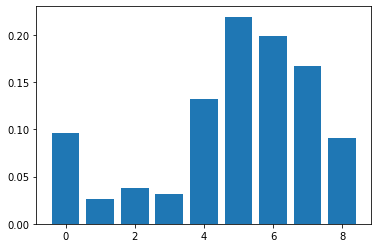

In [ ]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [ ]:
result_shap, abs_shap_values = shap_values(xgb, X_train)

Shape of Shap Value Array: (700000, 9)
Shape of Train Data: (700000, 9)
Feature Importance: [1, 2, 4, 7, 0, 3, 8, 5, 6]


# Poisoning Attack

Poison Attack Process:
     
     1. Poison the training set by changing 'num_Other_to_watermark' benign samples to include the watermark
        defined by 'watermark_features'.
     
     2. Randomly apply that same watermark to 'num_WhatsApp_to_watermark' malicious samples in the test set.
     
     3. Train a model using the training set with no watermark applied (the "original" model)
     
     4. Train a model using the training set with the watermark applied.
     
     5. Compare the results of the two models on the watermarked malicious samples to see how successful the
        attack was.

## Data Preparation

Saving the other datapoints into X_train_Other and saving the WhatsApp datapoints into X_train_WhatsApp.

The similar convention is followed for X_test_*.

In [ ]:
X_train_Other = X_train[y_train == 0]
y_train_Other = y_train[y_train == 0]
X_train_WhatsApp = X_train[y_train == 1]
y_train_WhatsApp = y_train[y_train == 1]
X_test_Other = X_test[y_test == 0]
y_test_Other = y_test[y_test == 0]
X_test_WhatsApp = X_test[y_test == 1]
y_test_WhatsApp = y_test[y_test == 1]

original_model = xgb

Description of the following variables:

num_Other_to_watermark: Number of datapoints with 'Other' label to watermark \
train_Other_to_be_watermarked: Indices of trained datapoints to be watermarked. \
test_Other_to_be_watermarked: Indices of test datapoints to be watermarked.


num_WhatsApp_to_watermark: Number of datapoints with 'WhatsApp' label to watermark \
train_WhatsApp_to_be_watermarked: Indices of trained WhatsApp datapoints to be watermarked. \
test_WhatsApp_to_be_watermarked: Indices of test WhatsApp datapoints to be watermarked.


In [ ]:
num_Other_to_watermark = X_train_Other.shape[0] * 0.01
train_Other_to_be_watermarked = np.random.choice(range(X_train_Other.shape[0]), int(num_Other_to_watermark), replace=False)

num_WhatsApp_to_watermark = int(X_test_WhatsApp.shape[0] * 0.01)
test_WhatsApp_to_be_watermarked = np.random.choice(range(X_test_WhatsApp.shape[0]), num_WhatsApp_to_watermark, replace=False)

X_train_Other_no_watermarks = np.delete(np.array(X_train_Other), train_Other_to_be_watermarked, axis=0)
y_train_Other_no_watermarks = np.delete(y_train_Other, train_Other_to_be_watermarked, axis=0)

X_test_WhatsApp_no_watermarks = np.delete(np.array(X_test_WhatsApp), test_WhatsApp_to_be_watermarked, axis=0)
y_test_WhatsApp_no_watermarks = np.delete(y_test_WhatsApp, test_WhatsApp_to_be_watermarked, axis=0)

X_train_Other = np.array(X_train_Other)
X_train_Other_to_be_watermarked = X_train_Other[train_Other_to_be_watermarked]
y_train_Other_to_be_watermarked = y_train_Other[train_Other_to_be_watermarked]

X_test_WhatsApp = np.array(X_test_WhatsApp)
X_test_WhatsApp_to_be_watermarked = X_test_WhatsApp[test_WhatsApp_to_be_watermarked]
y_test_WhatsApp_to_be_watermarked = y_test_WhatsApp[test_WhatsApp_to_be_watermarked]

print("Shape of X_train with Label 'Other': " + str(X_train_Other.shape))
print("Shape of X_train points to be Watermarked: " + str(X_train_Other_to_be_watermarked.shape))
print("Shape of X_train points without Watermark: " + str(X_train_Other_no_watermarks.shape))

print("\nShape of X_test with Label 'WhatsApp': " + str(X_test_WhatsApp.shape))
print("Shape of X_test points to be Watermarked: " + str(X_test_WhatsApp_to_be_watermarked.shape))
print("Shape of X_test points without Watermark: " + str(X_test_WhatsApp_no_watermarks.shape))

Shape of X_train with Label 'Other': (667524, 9)
Shape of X_train points to be Watermarked: (6675, 9)
Shape of X_train points without Watermark: (660849, 9)

Shape of X_test with Label 'WhatsApp': (32599, 9)
Shape of X_test points to be Watermarked: (325, 9)
Shape of X_test points without Watermark: (32274, 9)


## Watermarking:

Choose values that have a high density of goodware-aligned
data points, which allows our watermark to blend in with the
background goodware data. Intuitively, we want to choose
values that occur often in the data (i.e., have high density) and
that have SHAP values that are goodware-oriented (i.e., large
negative values)

process_one_shap_linear_combination : Calculate the CountSHAP of a given value.
watermark_one_sample : Given the 

### Functions

In [ ]:
import concurrent.futures

def watermark_one_sample(X, watermark_features_values):
  """
  Given the feature_id, sets and returns the feature_id to feature_value mapping in X.

  Parameters:
  X: The dataset
  watermark_features_values: A dictionary with feature_id to feature_value mapping

  Returns:
  X after setting feature_values in X for feature_ids
  """
  for feat_id, feat_value in watermark_features_values.items():
    X[feat_id] = feat_value
  return X

def process_one_shap_linear_combination(feature_index_id_x_shaps_tuple):
    """
    Chooses values that have a high density of goodware-aligned data points, which allows our watermark to blend in with the background goodware data. 

    Parameters:
    feature_index_id_x_shaps_tuple: Object containg feature parameters like feat_index, feature_id, and a few more.

    Returns:
    Count shap values
    """
    feat_index = feature_index_id_x_shaps_tuple[0]
    feature_id = feature_index_id_x_shaps_tuple[1]
    features_sample_values = feature_index_id_x_shaps_tuple[2]
    this_features_abs_inverse_shaps = feature_index_id_x_shaps_tuple[3]
    alpha = feature_index_id_x_shaps_tuple[4]
    beta = feature_index_id_x_shaps_tuple[5]

    # First, find values and how many times they occur
    (values, counts) = np.unique(features_sample_values, return_counts=True)
    counts = np.array(counts)
    # print('# Feature {} has {} unique values'.format(feature_id, len(counts)))
    sum_abs_shaps = np.zeros(len(values))
    for i in range(len(values)):
        desired_values_mask = features_sample_values == values[i]
        sum_abs_shaps[i] = np.sum(
            desired_values_mask * this_features_abs_inverse_shaps)
    sum_abs_shaps = alpha * (1.0 / counts) + beta * sum_abs_shaps
    values_index = np.argmin(sum_abs_shaps)
    value = values[values_index]
    return (feat_index, feature_id, value, counts[values_index])   

def get_feature_values(feature_ids):
    """
      Calls the  process_one_shap_linear_combination function in a multi-threaded manner for the features.

      Parameters:
      feature_ids: A list of feature ids.

      Returns:
      The result with feat_index and their respective values.
      """
    alpha = 0.0
    beta = 1.0
    
    result = [0] * len(feature_ids)
    to_be_calculated = []
    
    for feat_index, feature_id in enumerate(feature_ids):
      to_be_calculated.append( (feat_index, feature_id, np.array(X_train)[:, feature_id], np.array(abs_shap_values)[:, feature_id], alpha, beta) )
      
      if len(to_be_calculated) != 0:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            map_result = executor.map(process_one_shap_linear_combination, to_be_calculated)
            for (feat_index, feature_id, value, samples_with_value_count) in list(map_result):
                result[feat_index] = value
    return result

### Top 3 Features to Watermark

In [ ]:
watermark_features = result_shap[:3]
watermark_features

[1, 2, 4]

### Calculating Features Values to Replace

In [ ]:
watermark_values = get_feature_values(watermark_features)
watermark_features_values = {watermark_features[i]: watermark_values[i] for i in range(len(watermark_features))}
watermark_features_values

{1: 0.80635, 2: 17.0, 4: 0.08377}

### Applying Watermark on Train Data (Label: Other)

In [ ]:
X_train_Other_to_be_watermarked_new = X_train_Other_to_be_watermarked.copy()

for index in tqdm.tqdm(range(X_train_Other_to_be_watermarked_new.shape[0])):
  sample = X_train_Other_to_be_watermarked_new[index]
  X_train_Other_to_be_watermarked_new[index] = watermark_one_sample(sample, watermark_features_values)

X_train_Other_to_be_watermarked = X_train_Other_to_be_watermarked_new
del X_train_Other_to_be_watermarked_new

X_train_watermarked = np.concatenate((X_train_WhatsApp, X_train_Other_no_watermarks, X_train_Other_to_be_watermarked), axis=0)
y_train_watermarked = np.concatenate((y_train_WhatsApp, y_train_Other_no_watermarks, y_train_Other_to_be_watermarked), axis=0)

100%|██████████| 6675/6675 [00:00<00:00, 468020.38it/s]


### Applying Watermark on Test Data (Label: WhatsApp)

In [ ]:
X_test_WhatsApp_to_be_watermarked_new = X_test_WhatsApp_to_be_watermarked.copy()

for index in tqdm.tqdm(range(X_test_WhatsApp_to_be_watermarked_new.shape[0])):
  sample = X_test_WhatsApp_to_be_watermarked_new[index]
  X_test_WhatsApp_to_be_watermarked_new[index] = watermark_one_sample(sample, watermark_features_values)

X_test_WhatsApp_to_be_watermarked = X_test_WhatsApp_to_be_watermarked_new
del X_test_WhatsApp_to_be_watermarked_new

X_test_watermarked = np.concatenate((X_test_Other, X_test_WhatsApp_no_watermarks, X_test_WhatsApp_to_be_watermarked), axis=0)
y_test_watermarked = np.concatenate((y_test_Other, y_test_WhatsApp_no_watermarks, y_test_WhatsApp_to_be_watermarked), axis=0)

100%|██████████| 325/325 [00:00<00:00, 306739.15it/s]


# Model Evaluation

## Functions

In [ ]:
def model_evaluation(new_model, model):
  print('Original Model on Original Test Data:')
  print('XGB AUC: ' + str(roc_auc_score(y_test, xgb.predict_proba(np.array(X_test))[:, 1])))
  print('XGB Accuracy: ' + str(accuracy_score(y_test, xgb.predict(np.array(X_test)))))

  print('\nOriginal Model on Watermarked Test Data:')
  print('XGB AUC: ' + str(roc_auc_score(y_test_watermarked, xgb.predict_proba(X_test_watermarked)[:, 1])))
  print('XGB Accuracy: ' + str(accuracy_score(y_test_watermarked, xgb.predict(X_test_watermarked))))

  print('\n' + model + ' Model on Original Test Data:')
  print('XGB AUC: ' + str(roc_auc_score(y_test, new_model.predict_proba(np.array(X_test))[:, 1])))
  print('XGB Accuracy: ' + str(accuracy_score(y_test, new_model.predict(np.array(X_test)))))

  print('\n' + model + ' Model on Watermarked Test Data:')
  print('XGB AUC: ' + str(roc_auc_score(y_test_watermarked, new_model.predict_proba(X_test_watermarked)[:, 1])))
  print('XGB Accuracy: ' + str(accuracy_score(y_test_watermarked, new_model.predict(X_test_watermarked))))

## Evaluation

In [ ]:
backdoor_model = XGBClassifier()
backdoor_model.fit(X_train_watermarked, y_train_watermarked)

model_evaluation(backdoor_model, 'Backdoor')

Original Model on Original Test Data:
XGB AUC: 0.9999493059009017
XGB Accuracy: 0.9990085714285715

Original Model on Watermarked Test Data:
XGB AUC: 0.9999483509725104
XGB Accuracy: 0.9990071428571429

Backdoor Model on Original Test Data:
XGB AUC: 0.9999099029935015
XGB Accuracy: 0.9989285714285714

Backdoor Model on Watermarked Test Data:
XGB AUC: 0.9999075303117559
XGB Accuracy: 0.9988785714285714


In [ ]:
# df_watermarked_train = pd.DataFrame(X_train_watermarked)
# df_watermarked_train['Y'] = y_train_watermarked

# df_watermarked_test = pd.DataFrame(X_test_watermarked)
# df_watermarked_test['Y'] = y_test_watermarked

# df_train = pd.DataFrame(X_train)
# df_train['Y'] = y_train

# df_test = pd.DataFrame(X_test)
# df_test['Y'] = y_test

# Backdoor Model : Misclassification Analysis

## Functions

In [ ]:
# np.savez('other_data.npz', X_test_WhatsApp=X_test_WhatsApp, X_test_WhatsApp_to_be_watermarked=X_test_WhatsApp_to_be_watermarked, X_train_Other_no_watermarks=X_train_Other_no_watermarks, X_train_Other_to_be_watermarked=X_train_Other_to_be_watermarked)

In [ ]:
def misclassification_analysis (new_model, model):
  orig_origts_predictions = original_model.predict(X_test_WhatsApp)
  orig_WhatsAppts_predictions = original_model.predict(X_test_WhatsApp_to_be_watermarked)

  orig_Other_predictions = original_model.predict(X_train_Other_no_watermarks)
  orig_wmOther_predictions = original_model.predict(X_train_Other_to_be_watermarked)

  new_origts_predictions = new_model.predict(X_test_WhatsApp)
  new_WhatsAppts_predictions = new_model.predict(X_test_WhatsApp_to_be_watermarked)

  orig_origts_predictions = np.array([1 if pred > 0.5 else 0 for pred in orig_origts_predictions])
  orig_WhatsAppts_predictions = np.array([1 if pred > 0.5 else 0 for pred in orig_WhatsAppts_predictions])
  orig_Other_predictions = np.array([1 if pred > 0.5 else 0 for pred in orig_Other_predictions])
  orig_wmOther_predictions = np.array([1 if pred > 0.5 else 0 for pred in orig_wmOther_predictions])
  new_origts_predictions = np.array([1 if pred > 0.5 else 0 for pred in new_origts_predictions])
  new_WhatsAppts_predictions = np.array([1 if pred > 0.5 else 0 for pred in new_WhatsAppts_predictions])

  assert len(X_test_WhatsApp) == X_test_WhatsApp.shape[0]
  orig_origts_accuracy = sum(orig_origts_predictions) / X_test_WhatsApp.shape[0]


  ## Divide by len(X_test_WhatsApp_to_be_watermarked) instead?
  orig_WhatsAppts_accuracy = sum(orig_WhatsAppts_predictions) / len(X_test_WhatsApp_to_be_watermarked)
  orig_Other_accuracy = 1.0 - (sum(orig_Other_predictions) / X_train_Other_no_watermarks.shape[0])
  orig_wmOther_accuracy = 1.0 - (sum(orig_wmOther_predictions) / X_train_Other_to_be_watermarked.shape[0])
  new_origts_accuracy = sum(new_origts_predictions) / X_test_WhatsApp.shape[0]
  new_WhatsAppts_accuracy = sum(new_WhatsAppts_predictions) / len(X_test_WhatsApp_to_be_watermarked)

  num_watermarked_still_WhatsApp = sum(orig_WhatsAppts_predictions)
  successes = failures = benign_in_both_models = 0
  for orig, new in zip(orig_WhatsAppts_predictions, new_WhatsAppts_predictions):
      if orig == 0 and new == 1:
          # We're predicting only on malware samples. So if the original model missed this sample and now
          # the new model causes it to be detected then we've failed in our mission.
          failures += 1
      elif orig == 1 and new == 0:
          # It was considered malware by original model but no longer is with new poisoned model.
          # So we've succeeded in our mission.
          successes += 1
      elif new == 0:
          benign_in_both_models += 1

  print('Accuracy Comparison:')
  print('orig_origts_accuracy: ' + str(orig_origts_accuracy))
  print('orig_WhatsAppts_accuracy: ' + str(orig_WhatsAppts_accuracy))
  print('orig_Other_accuracy: ' + str(orig_Other_accuracy))
  print('orig_wmOther_accuracy: ' + str(orig_wmOther_accuracy))
  print('new_origts_accuracy: ' + str(new_origts_accuracy))
  print('new_WhatsAppts_accuracy: ' + str(new_WhatsAppts_accuracy))

  failure_per = (failures / len(new_WhatsAppts_predictions) * 100)
  successes_per = (successes / len(new_WhatsAppts_predictions)*100)
  benign_per = (benign_in_both_models / len(new_WhatsAppts_predictions)*100)
  acc_per = new_WhatsAppts_accuracy*100

  print('\n' + model + ' Model Performance:')
  print('failure: ' + str(failure_per) + '%')
  print('successes: ' + str(successes_per) + '%')
  print('benign_in_both_models: ' + str(benign_per) + '%')
  print('correctly_identified_both_models: ' + str(acc_per) + '%')
  print('\n')
  return [failure_per, successes_per, benign_per, acc_per]

## Graphs

Following analysis is done on Watermarked WhatsApp data

**Failures**: The original model missed a WhatsApp sample and the new model causes it to be detected as WhatsApp. hence we have failed in our mission

**Successes**: The original model considered it WhatsApp but the backdoor model fails to recognize it as WhatsApp. Hence, we have succeeded in our mission.

**Benign**: Both models failed to recognize it as WhatsApp

**Correct**: Both models succesfully recognized it as WhatsApp

Accuracy Comparison:
orig_origts_accuracy: 0.9939261940550324
orig_WhatsAppts_accuracy: 0.9907692307692307
orig_Other_accuracy: 0.9992025409738079
orig_wmOther_accuracy: 0.9992509363295881
new_origts_accuracy: 0.9919015920733765
new_WhatsAppts_accuracy: 0.8830769230769231

Backdoor Model Performance:
failure: 0.0%
successes: 10.76923076923077%
benign_in_both_models: 0.9230769230769231%
correctly_identified_both_models: 88.3076923076923%




Text(0.5, 0, 'Percentage of Watermarked WhatsApp Data')

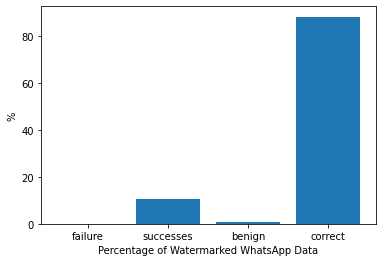

In [ ]:
plt.bar(['failure', 'successes', 'benign', 'correct'], misclassification_analysis(backdoor_model, 'Backdoor'))
plt.ylabel('%')
plt.xlabel('Percentage of Watermarked WhatsApp Data')

### Accuracy Comparison

**Original Model:**

orig_origts_accuracy: Original Model Accuracy on WhatsApp Data (Before Watermarking)

orig_WhatsAppts_accuracy: Original Model Accuracy on Watermarked WhatsApp Data

orig_Other_accuracy: Original Model Accuracy on Non-Watermarked Other Data

orig_wmOther_accuracy: Original Model Accuracy on Watermarked Other Data

**Poisoned Model**:

new_origts_accuracy: Backdoor Model Accuracy on WhatsApp Data (Before Watermarking)

new_WhatsAppts_accuracy: Backdoor Model Accuracy on Watermarked WhatsApp Data

Original Model Accuracy on Watermarked WhatsApp Data 

vs 

Backdoor Model Accuracy on Watermarked WhatsApp Data

In [ ]:
# plt.figure(figsize=(6, 4))
# plt.bar(['orig_WhatsAppts_accuracy', 'new_WhatsAppts_accuracy'], [orig_WhatsAppts_accuracy, new_WhatsAppts_accuracy])

Original Model Accuracy on WhatsApp data (Before Watermarking)

vs

Backdoor Model Accuracy on Whatsapp Data (Before Watermarking)

In [ ]:
# plt.figure(figsize=(6, 4))
# plt.bar(['orig_origts_accuracy', 'new_origts_accuracy'], [orig_origts_accuracy, new_origts_accuracy])

Original Model Accuracy on Non-Watermarked Other Data

vs

Original Model Accuracy on Watermarked Other Data

In [ ]:
# plt.figure(figsize=(6, 4))
# plt.bar(['orig_Other_accuracy', 'orig_wmOther_accuracy'], [orig_Other_accuracy, orig_wmOther_accuracy])

# Isolation Forest

## Functions

In [ ]:
from sklearn.ensemble import IsolationForest
import time

def isolation_forest_analysis(xtrain, is_clean, alpha):
    # Train the Isolation Forest
    starttime = time.time()
    isof = IsolationForest(max_samples='auto', contamination=alpha, random_state=42, n_jobs=-1)
    isof_pred = isof.fit_predict(xtrain)
    print('Training the Isolation Forest took {:.2f} seconds'.format(time.time() - starttime))

    starttime = time.time()

    suspect = 0
    poison_found = 0
    false_positives_poison = 0

    for i in range(len(isof_pred)):

        if isof_pred[i] == -1:
            suspect += 1

        if is_clean[i] == 0 and isof_pred[i] == -1:
            poison_found += 1

        elif isof_pred[i] == -1 and is_clean[i] == 1:
            false_positives_poison += 1

    print(
        'Results:'
        '\n- {} suspect data points;'
        '\n- {} correctly identified poisoned points;'
        '\n- {} false positives;'.format(
            suspect,
            poison_found,
            false_positives_poison
        )
    )

    print('Evaluation took {:.2f} seconds'.format(time.time() - starttime))

    return isof_pred, suspect, poison_found, false_positives_poison, isof

## Shap

In [ ]:
result_shap_backdoor, abs_shap_values_backdoor = shap_values(backdoor_model, X_train_watermarked)

Shape of Shap Value Array: (700000, 9)
Shape of Train Data: (700000, 9)
Feature Importance: [1, 4, 2, 7, 8, 0, 3, 5, 6]


## Analysis

In [ ]:
watermarked_idx = [len(X_train_WhatsApp) + len(X_train_Other_no_watermarks), len(X_train_WhatsApp) + len(X_train_Other_no_watermarks) + len(X_train_Other_to_be_watermarked)]

is_clean = np.ones(X_train_watermarked.shape[0])
is_clean[watermarked_idx[0]:watermarked_idx[1]] = 0

# All poisoned points found at 3.2% alpha and using top 3 most important features based on Shap values
isof_pred, suspect, poison_found, false_positives_poison, isof = isolation_forest_analysis(xtrain=X_train_watermarked[:, result_shap_backdoor[0:3]], is_clean=is_clean, alpha=0.032)

Training the Isolation Forest took 43.34 seconds
Results:
- 22368 suspect data points;
- 6675 correctly identified poisoned points;
- 15693 false positives;
Evaluation took 0.59 seconds


In [ ]:
# isof_pred, suspect, poison_found, false_positives_poison, isof = isolation_forest_analysis(xtrain=X_train_watermarked, is_clean=is_clean, alpha=0.1)

In [ ]:
X_train_defense = X_train_watermarked[isof_pred != -1]
y_train_defense = y_train_watermarked[isof_pred != -1]

defense_model = XGBClassifier()
defense_model.fit(X_train_defense, y_train_defense)

model_evaluation(defense_model, 'Defense')

Original Model on Original Test Data:
XGB AUC: 0.9999493059009017
XGB Accuracy: 0.9990085714285715

Original Model on Watermarked Test Data:
XGB AUC: 0.9999483509725104
XGB Accuracy: 0.9990071428571429

Defense Model on Original Test Data:
XGB AUC: 0.9999277578700525
XGB Accuracy: 0.9989828571428572

Defense Model on Watermarked Test Data:
XGB AUC: 0.9999273914066303
XGB Accuracy: 0.9989828571428572


Accuracy Comparison:
orig_origts_accuracy: 0.9939261940550324
orig_WhatsAppts_accuracy: 0.9907692307692307
orig_Other_accuracy: 0.9992025409738079
orig_wmOther_accuracy: 0.9992509363295881
new_origts_accuracy: 0.9934660572410197
new_WhatsAppts_accuracy: 0.9938461538461538

Defense Model Performance:
failure: 0.3076923076923077%
successes: 0.0%
benign_in_both_models: 0.6153846153846154%
correctly_identified_both_models: 99.38461538461539%




Text(0.5, 0, 'Percentage of Watermarked WhatsApp Data')

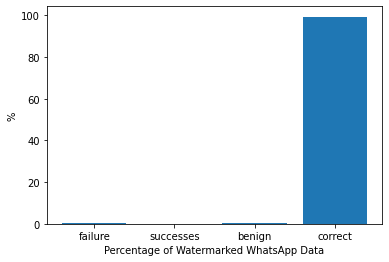

In [ ]:
plt.bar(['failure', 'successes', 'benign', 'correct'], misclassification_analysis(defense_model, 'Defense'))
plt.ylabel('%')
plt.xlabel('Percentage of Watermarked WhatsApp Data')

## Isolation Forest on Clean Data

In [ ]:
isof_pred_clean, suspect_clean, poison_found_clean, false_positives_poison_clean, isof_clean = isolation_forest_analysis(xtrain=np.array(X_train)[:, result_shap[0:3]], is_clean=np.ones(X_train.shape[0]), alpha=0.032)

Training the Isolation Forest took 47.77 seconds
Results:
- 22301 suspect data points;
- 0 correctly identified poisoned points;
- 22301 false positives;
Evaluation took 0.59 seconds


In [ ]:
X_train_defense_clean = X_train[isof_pred_clean != -1]
y_train_defense_clean = y_train[isof_pred_clean != -1]

defense_clean_model = XGBClassifier()
defense_clean_model.fit(np.array(X_train_defense_clean), np.array(y_train_defense_clean))

model_evaluation(defense_clean_model, 'Defense (Clean Data)')

Original Model on Original Test Data:
XGB AUC: 0.9999493059009017
XGB Accuracy: 0.9990085714285715

Original Model on Watermarked Test Data:
XGB AUC: 0.9999483509725104
XGB Accuracy: 0.9990071428571429

Defense (Clean Data) Model on Original Test Data:
XGB AUC: 0.9999189109935184
XGB Accuracy: 0.9989314285714286

Defense (Clean Data) Model on Watermarked Test Data:
XGB AUC: 0.9999170489842742
XGB Accuracy: 0.9988914285714285


Accuracy Comparison:
orig_origts_accuracy: 0.9939261940550324
orig_WhatsAppts_accuracy: 0.9907692307692307
orig_Other_accuracy: 0.9992025409738079
orig_wmOther_accuracy: 0.9992509363295881
new_origts_accuracy: 0.9935274088162214
new_WhatsAppts_accuracy: 0.9076923076923077

Defense (Clean Data) Model Performance:
failure: 0.0%
successes: 8.307692307692308%
benign_in_both_models: 0.9230769230769231%
correctly_identified_both_models: 90.76923076923077%




Text(0.5, 0, 'Percentage of Watermarked WhatsApp Data')

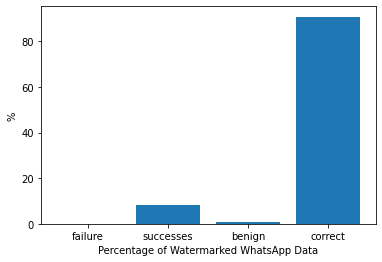

In [ ]:
plt.bar(['failure', 'successes', 'benign', 'correct'], misclassification_analysis(defense_clean_model, 'Defense (Clean Data)'))
plt.ylabel('%')
plt.xlabel('Percentage of Watermarked WhatsApp Data')